# Basic photometric analyses

gPhoton2 extracts photometric measurements using the aperture photometry tools of `astropy`'s `photutils` package.

In [1]:
from rich import print
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gPhoton.analysis.utils as utils # a set of helpful data analysis functions

In [ ]:
photomfiles = {'APER6':f'test_data/e23456//e23456-nd-f0120-b00-movie-photom-12_8.csv', # aper6
               'APER7':f'test_data/e23456//e23456-nd-f0120-b00-movie-photom-17_3.csv', # aper7
               'APER8':f'test_data/e23456//e23456-nd-f0120-b00-movie-photom-30_0.csv',}# aper8

First we will open a photometry file that has been output directly from gPhoton2. Cross-referencing the [filenaming reference](#filenaming_conventions.md) will permit you to identify that this is a photometry file for the 0th leg of eclipse 23456 in the NUV band with 60-second time bins and 12.8" radius apertures. This aperture radius corresponds to what the mission designated 

In [15]:
photom_APER6 = pd.read_csv(photomfiles['APER6'])
photom_APER6.head()

,xcentroid,ycentroid,area,segment_flux,elongation,eccentricity,equivalent_radius,orientation,max_value,maxval_xindex,...,artifact_flag_5,artifact_flag_6,artifact_flag_7,artifact_flag_8,artifact_flag_9,artifact_flag_10,artifact_flag_11,artifact_flag_12,artifact_flag_13,artifact_flag_14
0,1475.455495,77.000000,2.0,-1.262053,1.994049,0.865162,0.797885,0.000000,-0.081044,1475,...,12,12,12,12,12,12,12,12,12,12
1,1526.000000,83.499629,2.0,12.307364,2.000000,0.866025,0.797885,90.000000,9.614330,1526,...,12,12,13,13,13,13,13,13,13,12
2,1515.351158,93.584657,92.0,872.138351,2.256933,0.896482,5.411516,85.961426,27.325287,1516,...,12,12,12,4,12,12,12,12,12,12
3,1402.531181,88.510167,4.0,28.404093,1.006050,0.109504,1.128379,53.391200,11.763075,1403,...,12,12,12,12,12,12,12,12,12,12
4,1444.994432,89.000000,3.0,14.752273,2.988250,0.942345,0.977205,0.000000,8.529310,1444,...,12,12,12,12,12,12,12,12,12,12


Note that there is a huge number of columns in the photometry files. The exact number depends on the observing mode, because many columns are repeated for every frame of a movie, if the photometry was performed on a movie file. These repeating frames will be appended with a frame index `_[N]`. The column definitions more fully described in **[REFERENCE TBD]**.

The columns that we care about the most right now will be:
| Column | Description |
|--------|-------------|
| [xy]center | Center of the aperture in count image pixel coordinates
| [xy]centroid | Centroid (mean position) of the source in count image pixel coordinates
| ra | Right ascention of aperture center in J2000 decimal degrees
| dec | Declination of aperture center in J2000 decimal degrees
| aperture_sum[_N] | Integrated counts within the aperture (pixel values, interpolated, of each bin if applicable)
| t0[_N] | Start time in "GALEX time" (of each bin if applicable)
| t1[_N] | Stop time in "GALEX time" (of each bin if applicable)
| expt[_N] | Effective exposure time in seconds within each bin
| exptime | Total effective exposure time across the visit
| artifact_flag[_N] | Artifact flag of pixels within the aperture (of each bin if applicable)


### Photometry on the full depth observation

range: 0.5418304085734884 563.4274167920412

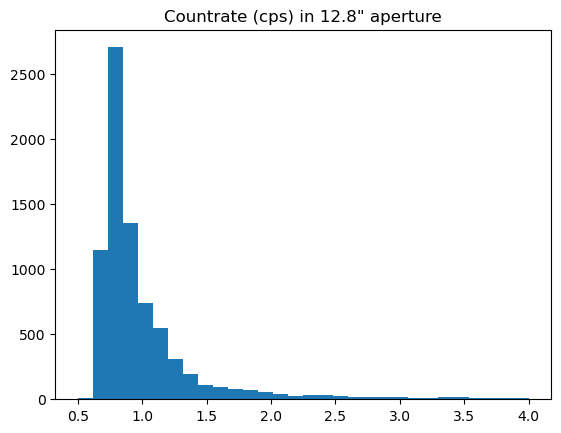

In [22]:
# Counts per second is just aperture_sum / expt
counts_per_second_APER6 = photom_APER6['aperture_sum'] / photom_APER6['exptime']
print('range:',
      np.nanmin(counts_per_second_APER6),
      counts_per_second_APER6.iloc[np.where(np.isfinite(counts_per_second_APER6))].max())
plt.hist(counts_per_second_APER6, bins=30, range=(0.5,4))
plt.title('Countrate (cps) in 12.8" aperture')

# The standard error is just sqrt(N)/expt
counts_per_second_std_err_APER6 = np.sqrt(photom_APER6['aperture_sum']) / photom_APER6['exptime']

Note that the exposure times are the same for all sources in an observation (i.e. within a single photometry file output from gPhoton2). This means that exposure time will only be valid on the "full depth" regions of the image. If gPhoton2 is run in "automatica photometry" mode, where it automatically identifies and extracts photometry from images, then it will decline to make detections in any region of the image that is _not_ full-depth. If run in "forced photometry" by providing a list of target positions as an input, then some of the sources in the output may not be "full depth" and should be excluded by analyses by cross-referencing the "COVERAGE" HDU in the image file.

The examples in this notebook were produced by automatic photometry mode, so they all had full-depth exposure.

range: 0.555401522739948 36.15925211424764

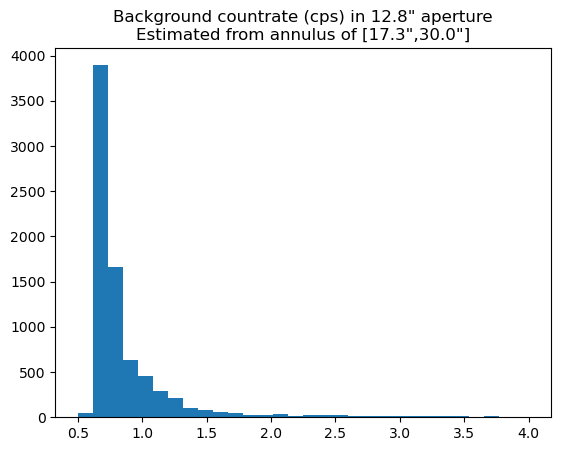

In [24]:
# Estimate background in an annulus
photom_APER7 = pd.read_csv(photomfiles['APER7'])
photom_APER8 = pd.read_csv(photomfiles['APER8'])
# exposure time should be the same for all apertures
counts_per_second_APER7 = photom_APER7['aperture_sum'] / photom_APER7['exptime']
counts_per_second_APER8 = photom_APER7['aperture_sum'] / photom_APER8['exptime']

aperture_area = np.pi*(12.8**2)
annulus_area = np.pi*(30.0**2 - 17.3**2)
aperture_sum_APER7 = photom_APER7['aperture_sum']
aperture_sum_APER8 = photom_APER8['aperture_sum']
background_counts_per_second_APER6 = (aperture_sum_APER8 - aperture_sum_APER7) * (aperture_area / annulus_area) / photom_APER6['exptime']

print('range:',
      np.nanmin(background_counts_per_second_APER6),
      background_counts_per_second_APER6.iloc[np.where(np.isfinite(background_counts_per_second_APER6))].max())
plt.hist(background_counts_per_second_APER6, bins=30, range=(0.5,4))
plt.title(f'Background countrate (cps) in 12.8" aperture\nEstimated from annulus of [17.3",30.0"]')

# The standard error is just sqrt(N)/expt, scaled to the aperture area
background_counts_per_second_std_err_APER6 = np.sqrt(aperture_sum_APER8 - aperture_sum_APER7) * (aperture_area / annulus_area) / photom_APER6['exptime']


range: -31.167074239470303 553.3936219571112

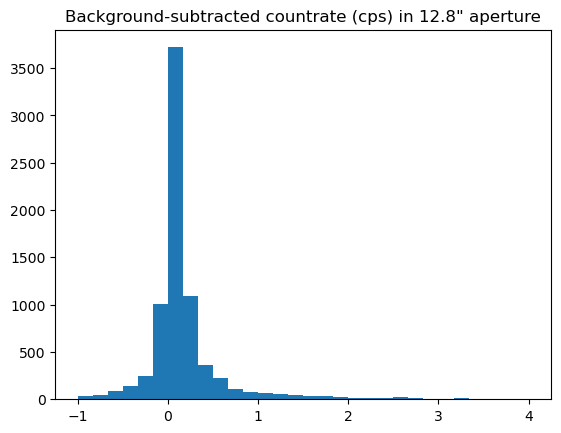

In [25]:
# Calculate the background-subtracted countrate
counts_per_second_bgsub_APER6 = counts_per_second_APER6 - background_counts_per_second_APER6
print('range:',
      counts_per_second_bgsub_APER6.iloc[np.where(np.isfinite(counts_per_second_bgsub_APER6))].min(),
      counts_per_second_bgsub_APER6.iloc[np.where(np.isfinite(counts_per_second_bgsub_APER6))].max())
plt.hist(counts_per_second_bgsub_APER6, bins=30, range=(-1,4))
plt.title('Background-subtracted countrate (cps) in 12.8" aperture')

# The standard error is computed by addition in quadrature
counts_per_second_bgsub_std_err_APER6 = np.sqrt(counts_per_second_std_err_APER6**2 + background_counts_per_second_std_err_APER6**2) / photom_APER6['exptime']

You will have noted that doing background estimation and subtraction in this way generates a large number of _negative_ fluxes. This is due to three main factors.
1. The annulus capturing some of the light of the main source.
2. Sources contaminating the annulus with stray light.
3. Failure to take into account that the GALEX diffuse sky background is (mostly) Poisson.

We will attempt to mitigate these problems in the 'advanced photometry' notebook by using a better model.

___

### Converting to other flux units

The conversion facts from counts-per-second (cps) to other standard flux units are described at http://asd.gsfc.nasa.gov/archive/galex/FAQ/counts_background.html.

The following functions will convert between counts-per-second, AB Mag, and flux (erg sec^-1 cm^-2 A^-1).

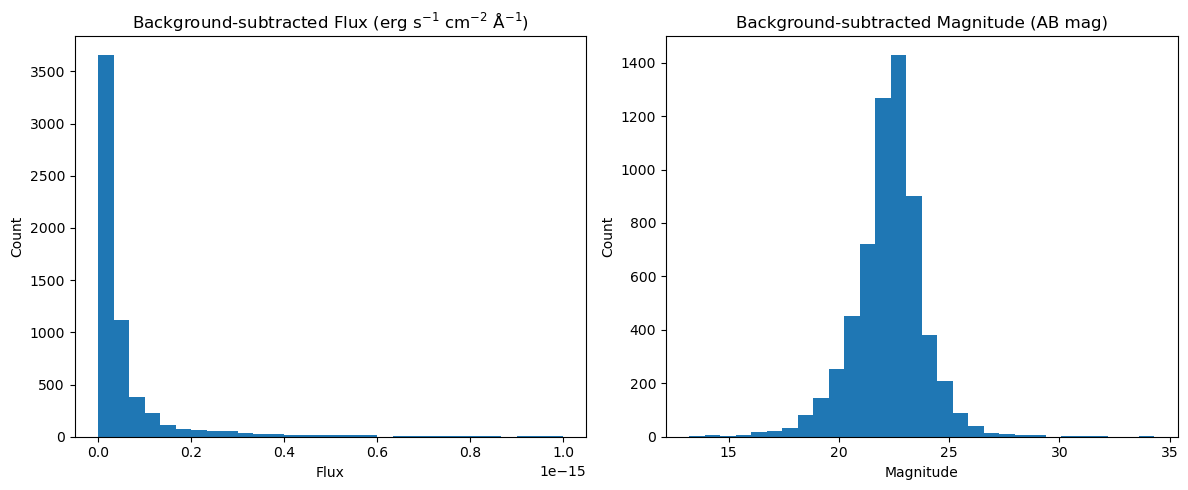

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Convert to flux units
flux_bgsub_APER6 = utils.countrate_to_flux(counts_per_second_bgsub_APER6, 'NUV')

axes[0].hist(flux_bgsub_APER6, bins=30, range=(0, 1e-15))
axes[0].set_title('Background-subtracted Flux (erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)')
axes[0].set_xlabel('Flux')
axes[0].set_ylabel('Count')

# Convert to AB magnitudes
mag_bgsub_APER6 = utils.countrate_to_magnitude(counts_per_second_bgsub_APER6,'NUV')

axes[1].hist(mag_bgsub_APER6, bins=30)
axes[1].set_title('Background-subtracted Magnitude (AB mag)')
axes[1].set_xlabel('Magnitude')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [31]:
# Flux units are linear, so you can just convert the cps uncertainties directly to flux
flux_bgsub_APER6_err = utils.countrate_to_flux(counts_per_second_bgsub_std_err_APER6, 'NUV')

# Magnitudes are logarithmic, which means that the uncertainties are not stricly symmetric.
# They are linear under an approximation near zero, though, ...
#                       so most astronomers only ever report a single value for uncertainty on magnitudes.
mag_bgsub_APER6_err = np.abs(utils.countrate_to_magnitude(counts_per_second_bgsub_APER6 +
                                                    counts_per_second_bgsub_std_err_APER6, 'NUV') -
                             utils.countrate_to_magnitude(counts_per_second_bgsub_APER6, 'NUV'))
# The error in the other direction would subtract the standard error from the background-subtracted countrate.

print(f'Median flux error: {np.nanmedian(flux_bgsub_APER6_err):.2e} erg s^-1 cm^-2 Å^-1')
print(f'Mean magnitude error: {np.nanmean(mag_bgsub_APER6_err):.4f} AB mag')

Median flux error: 3.68e-21 erg s^-1 cm^-2 Å^-1

Mean magnitude error: 0.0012 AB mag

___

### Aperture corrections

There are two published aperture correction tables. Both map an aperture correction to the standard GALEX aperture radii in both bands.

The first is described in Figure 4 from Morissey, et al., 2007. It maps to `APER[1-10]`. We believe that this is the more reliable of the published aperture corrections, and it is the one that the mission team used.

The second is described in Table 1 from http://www.galex.caltech.edu/researcher/techdoc-ch5.html. It only maps to `APER[1-7]`, which are the apertures most appropriate for the majority of scientific analyses.

The following functions take an aperture radius in decimal degrees and interpolate a aperture correction based on these two published references. You can see that the proposed corrections different quite a lot.

In [34]:
# In our example we use a 12.8" aperture
aperture_radius = 12.8/3600. # in units of degrees
apcor1 = utils.aperture_correction_method_1(aperture_radius, 'NUV') # intermediate apertures (e.g. 15") will get interpolated corrections
apcor2 = utils.aperture_correction_method_2(aperture_radius, 'NUV')
print(f'Aperture correction (method 1, Morissey+2007): {apcor1:.3f} mag (BEST OPTION)')
print(f'Aperture correction (method 2, GALEX tech doc): {apcor2:.3f} mag')

Aperture correction (method 1, Morissey+2007): 0.090 mag (BEST OPTION)

Aperture correction (method 2, GALEX tech doc): 0.060 mag

Note that there is a 30% difference in the number between these two methods!

The uncertainties associated with the pre-defined aperture corrections are unknown. Note that the scale of the aperture correction will often be orders of mangitude larger than the standard error of the measurement. The aperture correction could potential inject a sigificant spurious signal! Use caution.

In magnitudes, the aperture correction should be _subtracted_. In flux and cps units, it is multiplicative.

____

### Plotting a light curve with error bars

The _gPhoton_ tools uniquely enable sub-visit time domain analyes with GALEX. Therefore, an extremely common desired activity is to _make a light curve_.

So, let's plot _every_ light curve in our example photometry file. We will calculate countrate in each time bin and plot them against a timestamp for each bin. We will also identify any bins that are affected by either the "hotspot" or "wide edge" flags. For simplicity, we won't apply a background or aperture correction, and we will do everything in counts-per-second.

Note: Within a single _gPhoton2_ photometry file, each timestamp and exposure time column will be filled with identical values. This is somewhat wasteful in terms of bits, but it dramatically simplifies merging photometry tables across the whole mission for analysis. (And once converted into modern formats like `parquet` or put into a database, the dictionary compression makes any data volume increase negligible.) However, for the sake of pedagogy, we will pretend that all of these values are _not_ identical.

In [35]:
aperture_sums = np.array([APER6_photom[f'aperture_sum_{N}'].values for N in range(nframes)]).T
expts = np.array([APER6_photom[f'expt_{N}'].values for N in range(nframes)]).T
t0s = np.array([APER6_photom[f't0_{N}'].values for N in range(nframes)]).T
t1s = np.array([APER6_photom[f't1_{N}'].values for N in range(nframes)]).T # equivalent to t0s + expts

# Bit mask: set artifact_flags to 1 if bit 0 is set, 8 if bit 3 is set, else 0
artifact_flags = np.zeros_like(aperture_sums, dtype=int)
for N in range(nframes):
    flags = APER6_photom[f'artifact_flag_{N}'].values
    artifact_flags[:, N] = np.where(flags & 1, 1, np.where(flags & 4, 4, 0))

# Now divide the aperture sums by the exposure times to get the counts per second
cps = aperture_sums / expts
cps_err = np.sqrt(aperture_sums) / expts

print(f'Now we have {len(cps)} lightcurves with {len(cps[0])} bins each.')

Now we have 7946 lightcurves with 15 bins each.

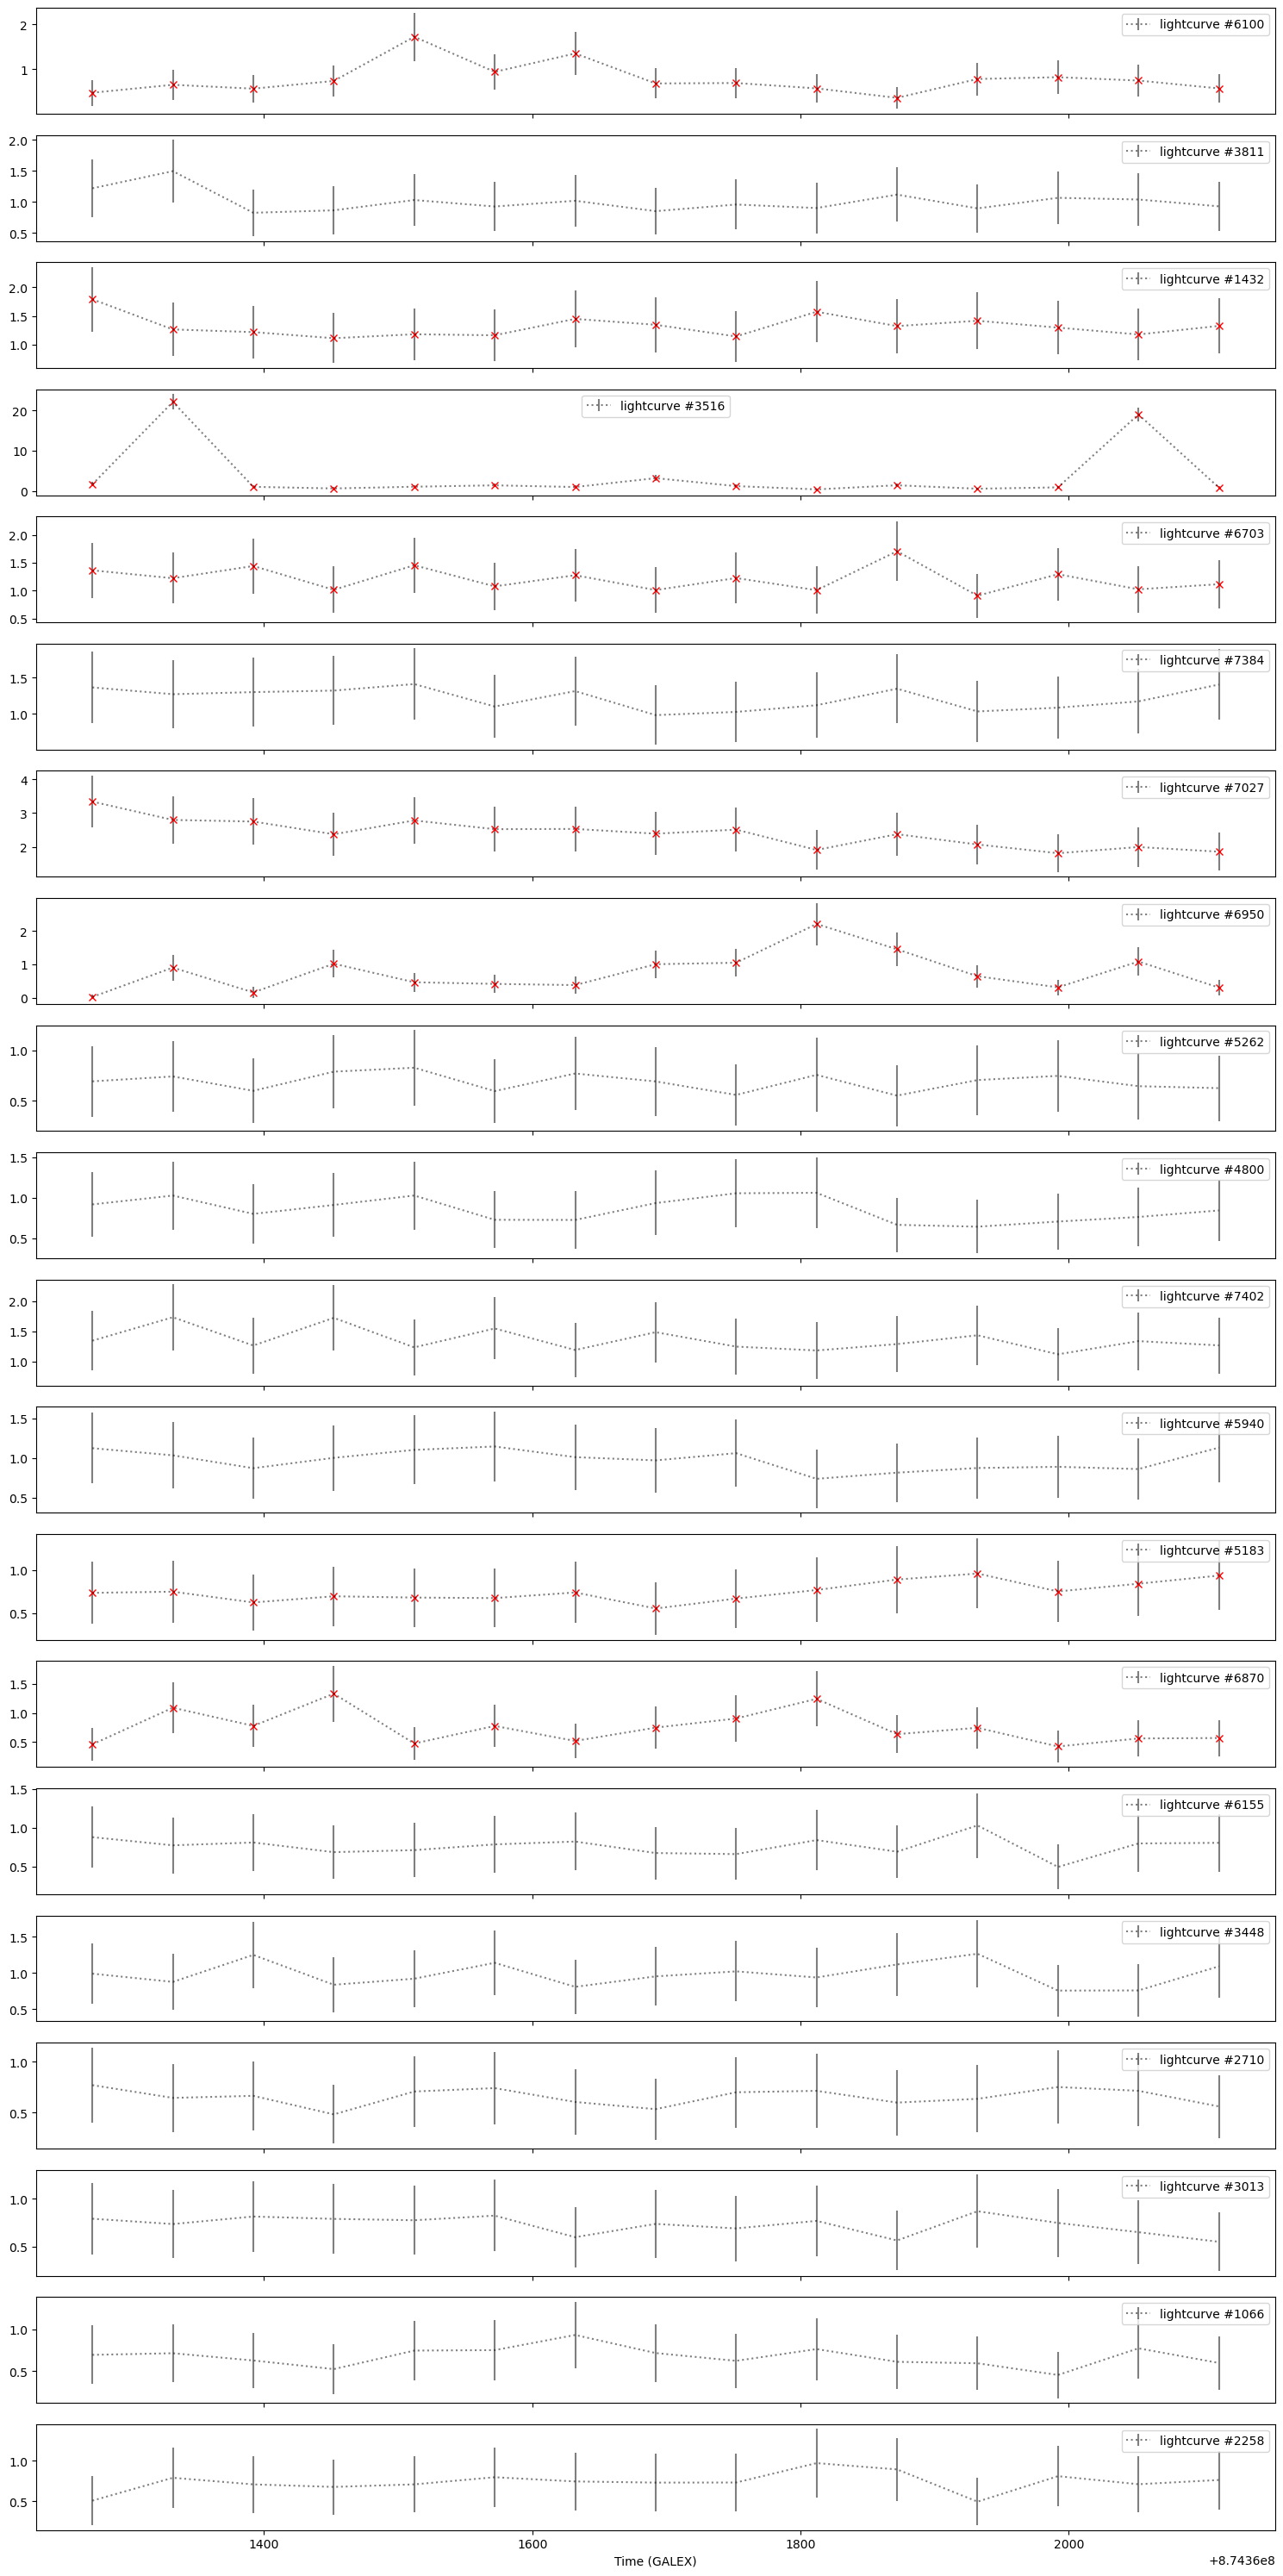

In [36]:
# It would be ridiculous to plot all of them, so let's pick 20 at random.
np.random.seed(100)
# Error bars will be 3-sigma. The flagged data points will be marked with red X's.
# Note that we generally recommend exluding from analyses any light curve with flagged bins... you'll see why...
fig, axes = plt.subplots(20, 1, figsize=(15, 30), sharex=True)
idx = np.random.choice(len(cps), 20, replace=False)
for ax, i in zip(axes, idx):
    ax.errorbar(t0s[i] + (t1s[i]-t0s[i])/2, cps[i], yerr=3*cps_err[i], fmt='k:', alpha=0.5, label=f'lightcurve #{i}')
    flag_ix = np.where(artifact_flags[i] != 0)[0]
    ax.plot(t0s[i][flag_ix] + (t1s[i][flag_ix]-t0s[i][flag_ix])/2, cps[i][flag_ix], 'rx')
    ax.legend()
axes[-1].set_xlabel('Time (GALEX)')
plt.tight_layout()
plt.show()